# Vehicle Detection Project

## Cell 1: All the import statements needed for this project

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
import pickle

## Cell 2: Util functions

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True,
                       visualize=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                
        else: 
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Cell 3: Function to extract features of a single image window

In [3]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Cell 5: Load images

In [4]:
# Read in cars and notcars
cars = []
notcars = []
car_images = glob.glob('vehicles/*/*.png')
for image in car_images:
    cars.append(image)
print(len(cars))

nocar_images = glob.glob('non-vehicles/*/*.png')
for image in nocar_images:
    notcars.append(image)
print(len(notcars))
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 8790
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

8792
8968


## Data Example Plot

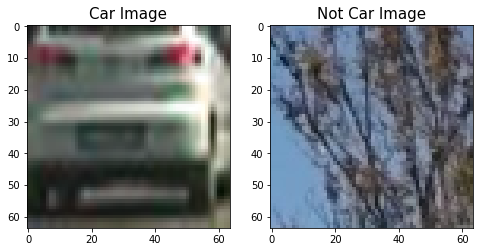

In [5]:
# Choose a random indices for plotting
car_idx = np.random.randint(0, len(cars))
notcar_idx = np.random.randint(0, len(notcars))

# Read car and non-car image
car_image = mpimg.imread(cars[car_idx])
notcar_image = mpimg.imread(notcars[notcar_idx])

# Plot an example of a vehicle and non-vehicle image 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=15)
ax2.imshow(notcar_image)
ax2.set_title('Not Car Image', fontsize=15)
plt.savefig('output_images/car_and_notcar.png')

## Data Example HOG

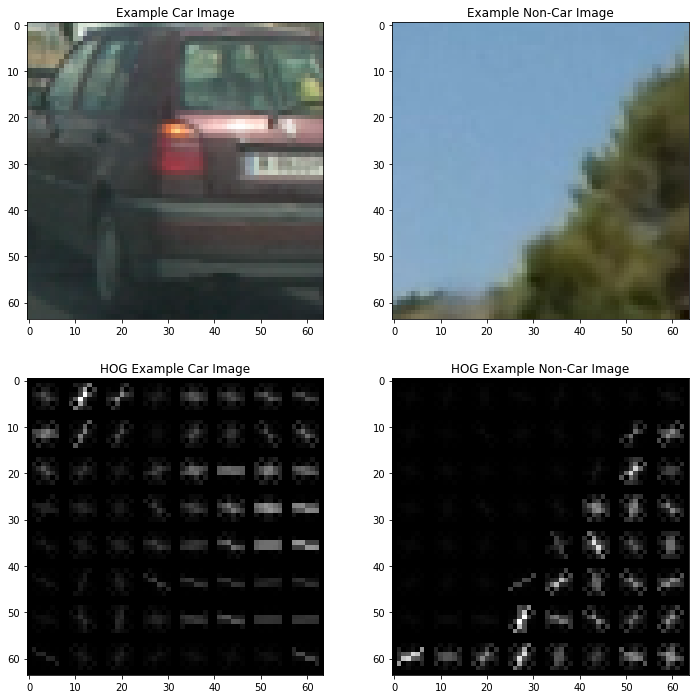

In [6]:

# Choose a random indices for plotting
car_idx = np.random.randint(0, len(cars))
notcar_idx = np.random.randint(0, len(notcars))

# Read car and non-car image
car_image = mpimg.imread(cars[car_idx])
notcar_image = mpimg.imread(notcars[notcar_idx])

gray_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
gray_notcar = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

orient = 12
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features_car, hog_image_car = get_hog_features(gray_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features_notcar, hog_image_notcar = get_hog_features(gray_notcar, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(222)
plt.imshow(notcar_image, cmap='gray')
plt.title('Example Non-Car Image')

plt.subplot(223)
plt.imshow(hog_image_car, cmap='gray')
plt.title('HOG Example Car Image')
plt.subplot(224)
plt.imshow(hog_image_notcar, cmap='gray')
plt.title('HOG Example Non-Car Image')


plt.savefig('examples/hog.png')

## Different Color Space for HOG

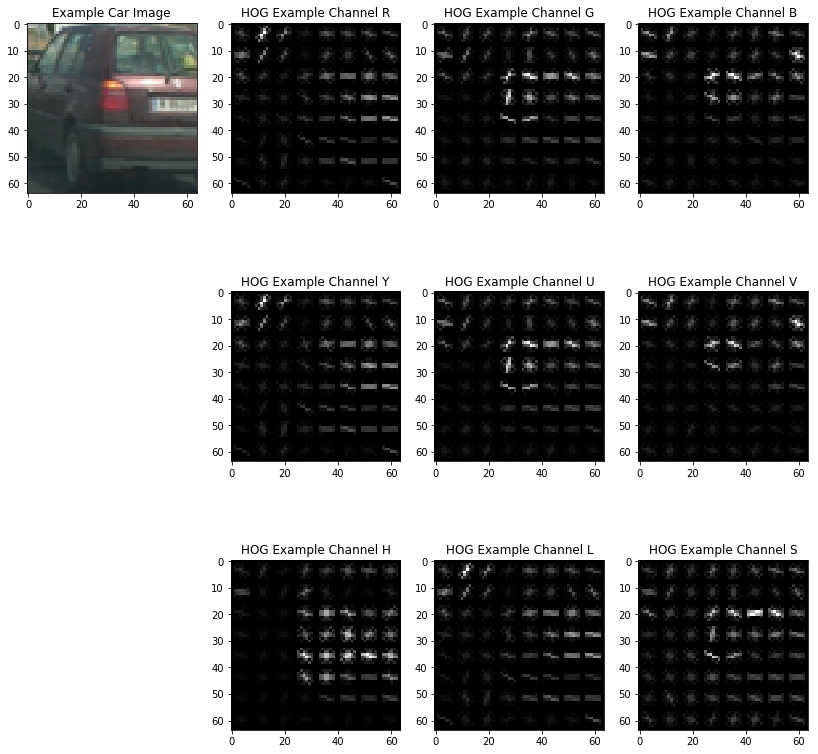

In [7]:
# YCrCb 
image = convert_color(car_image)
# Call our function with vis=True to see an image output per channel
_, hog_image_car_R = get_hog_features(image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_G = get_hog_features(image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_B = get_hog_features(image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# YUV 
image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
# Call our function with vis=True to see an image output per channel
_, hog_image_car_Y = get_hog_features(image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_U = get_hog_features(image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_V = get_hog_features(image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# HLS
image = cv2.cvtColor(car_image, cv2.COLOR_RGB2HLS)
# Call our function with vis=True to see an image output per channel
_, hog_image_car_H = get_hog_features(image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_L = get_hog_features(image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_S = get_hog_features(image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(14,14))
plt.subplot(341)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(342)
plt.imshow(hog_image_car_R, cmap='gray')
plt.title('HOG Example Channel R')

plt.subplot(343)
plt.imshow(hog_image_car_G, cmap='gray')
plt.title('HOG Example Channel G')
plt.subplot(344)
plt.imshow(hog_image_car_B, cmap='gray')
plt.title('HOG Example Channel B')


plt.subplot(346)
plt.imshow(hog_image_car_Y, cmap='gray')
plt.title('HOG Example Channel Y')

plt.subplot(347)
plt.imshow(hog_image_car_U, cmap='gray')
plt.title('HOG Example Channel U')
plt.subplot(348)
plt.imshow(hog_image_car_V, cmap='gray')
plt.title('HOG Example Channel V')

plt.subplot(3,4,10)
plt.imshow(hog_image_car_H, cmap='gray')
plt.title('HOG Example Channel H')

plt.subplot(3,4,11)
plt.imshow(hog_image_car_L, cmap='gray')
plt.title('HOG Example Channel L')
plt.subplot(3,4,12)
plt.imshow(hog_image_car_S, cmap='gray')
plt.title('HOG Example Channel S')

plt.savefig('examples/hog2.png')

## Different Parameters for HOG

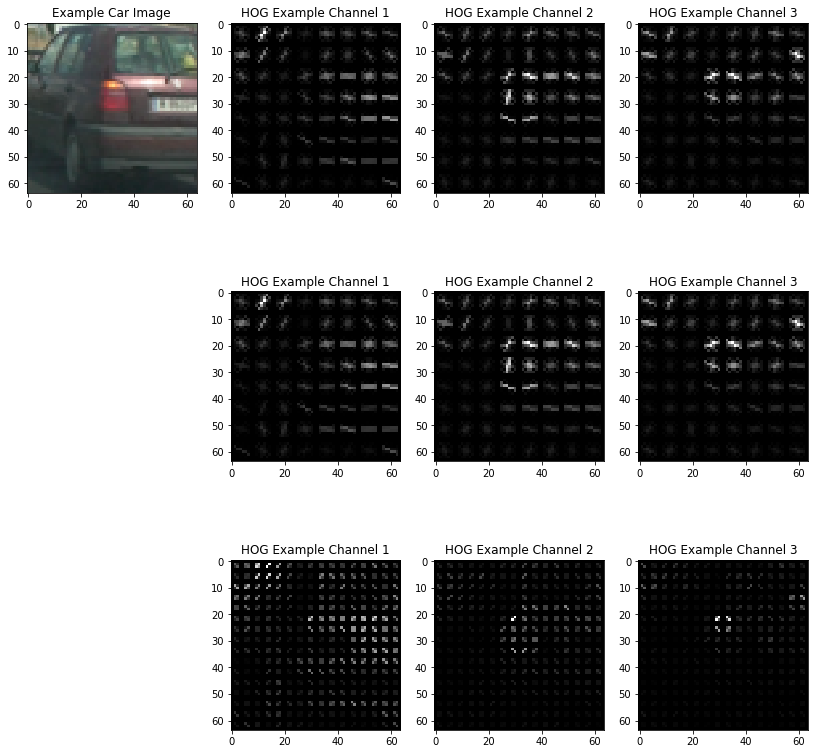

In [8]:
# YCrCb 
image = convert_color(car_image)
# Parameter set 1
orient = 12
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output per channel
_, hog_image_car_A1 = get_hog_features(image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_A2 = get_hog_features(image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_A3 = get_hog_features(image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Parameter set 2
orient = 12
pix_per_cell = 8
cell_per_block = 4
# Call our function with vis=True to see an image output per channel
_, hog_image_car_B1 = get_hog_features(image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_B2 = get_hog_features(image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_B3 = get_hog_features(image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Parameter set 3
orient = 12
pix_per_cell = 4
cell_per_block = 2
# Call our function with vis=True to see an image output per channel
_, hog_image_car_C1 = get_hog_features(image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_C2 = get_hog_features(image[:,:,1], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
_, hog_image_car_C3 = get_hog_features(image[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(14,14))
plt.subplot(341)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(342)
plt.imshow(hog_image_car_A1, cmap='gray')
plt.title('HOG Example Channel 1')

plt.subplot(343)
plt.imshow(hog_image_car_A2, cmap='gray')
plt.title('HOG Example Channel 2')
plt.subplot(344)
plt.imshow(hog_image_car_A3, cmap='gray')
plt.title('HOG Example Channel 3')


plt.subplot(346)
plt.imshow(hog_image_car_B1, cmap='gray')
plt.title('HOG Example Channel 1')

plt.subplot(347)
plt.imshow(hog_image_car_B2, cmap='gray')
plt.title('HOG Example Channel 2')
plt.subplot(348)
plt.imshow(hog_image_car_B3, cmap='gray')
plt.title('HOG Example Channel 3')

plt.subplot(3,4,10)
plt.imshow(hog_image_car_C1, cmap='gray')
plt.title('HOG Example Channel 1')

plt.subplot(3,4,11)
plt.imshow(hog_image_car_C2, cmap='gray')
plt.title('HOG Example Channel 2')
plt.subplot(3,4,12)
plt.imshow(hog_image_car_C3, cmap='gray')
plt.title('HOG Example Channel 3')

plt.savefig('examples/hog3.png')


## Cell 4: Search qualified windows in windows_list (need to calculate hog multiple times)

In [9]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Cell 4.1 Hog Sub-sampling Window Search

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img,ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, \
              spatial_size, hist_bins):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above   
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_window = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                on_windows.append(on_window)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img,on_windows

## Cell 6: Parameters

In [11]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 650] # Min and max in y to search in slide_window()

## Cell 7: Data preprocess

In [12]:
car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## Cell 8 : Training

In [21]:
# Use a linear SVC
svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

pickle.dump( svc, open( "./svc_pickle.p", "wb" ) )

15.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


/home/echo/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Cell 8.1: Parameter Tuning 

In [ ]:
from sklearn.model_selection import GridSearchCV
# Use a linear SVC
parameters = {'C':[0.01,0.1,0.5,1,5,10]}
svr = LinearSVC(max_iter=5000)
clf = GridSearchCV(svr, parameters,cv=5)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Best Parameter
print('Best C Value = ',clf.best_params_)
pickle.dump( svc, open( "./svc_pickle.p", "wb" ) )

## Cell 9: Prediction using windows search

3.21 Seconds to Search...


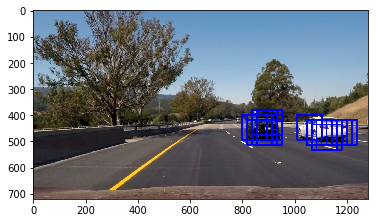

In [22]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
image_scaled = image.astype(np.float32)/255
t=time.time()
windows = slide_window(image_scaled, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))

hot_windows = search_windows(image_scaled, windows, svc, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Search...')
plt.imshow(window_img)
plt.show()

## Cell 9.1 Prediction using Hog Sub-sampling Window Search

0.38 Seconds to Search...


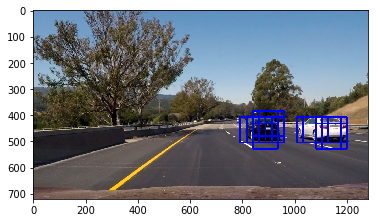

In [23]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
ystart = y_start_stop[0]
ystop = y_start_stop[1]
scale = 1.5
t=time.time()
window_img, window_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, \
                                    cell_per_block, spatial_size, hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to Search...')
plt.imshow(window_img)
plt.show()

## Cell 9.3: Multiscale

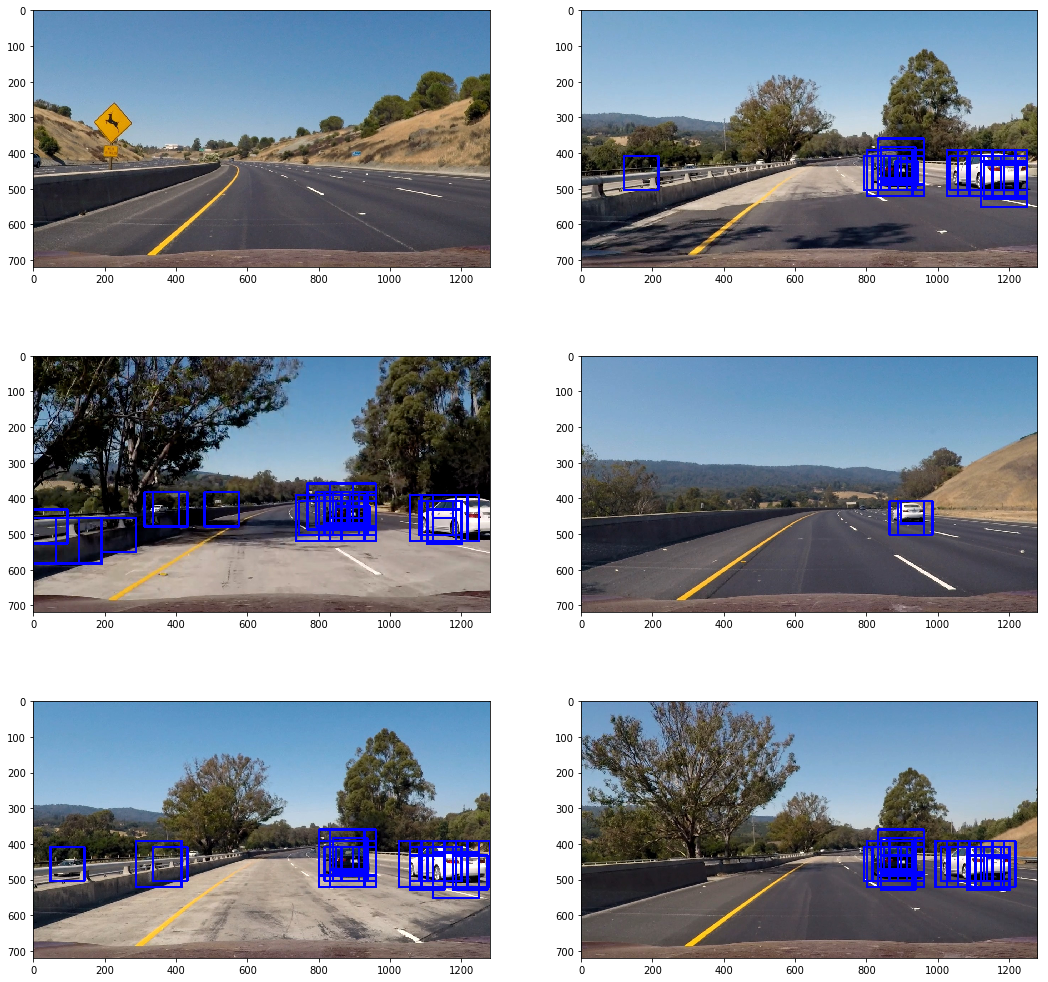

In [85]:
def find_cars_multiscales(image, ystart, ystop, scale_list, svc, X_scaler, orient, pix_per_cell, \
                          cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(image)
        #1) Create an empty list to receive positive detection windows
    on_windows = []
    img = image.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    for scale in scale_list:
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch_scaled = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), \
                                                                  np.int(imshape[0]/scale)))
        else:
            ctrans_tosearch_scaled = np.copy(ctrans_tosearch)

        ch1 = ctrans_tosearch_scaled[:,:,0]
        ch2 = ctrans_tosearch_scaled[:,:,1]
        ch3 = ctrans_tosearch_scaled[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch_scaled[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    on_window = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                    on_windows.append(on_window)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+\
                                                                          win_draw+ystart),(0,0,255),6) 
    return draw_img,on_windows

test_images_path = glob.glob('test_images/test*.jpg')
test_images = []
for test_image_path in test_images_path:
    test_image = mpimg.imread(test_image_path)
    test_images.append(test_image)
    
ystart = y_start_stop[0]
ystop = y_start_stop[1]
scale = [1,1.5,2]

window_img1, window_list1 = find_cars_multiscales(test_images[0], ystart, ystop, scale, svc, \
                                                  X_scaler, orient, pix_per_cell, cell_per_block, \
                                                  spatial_size, hist_bins)
window_img2, window_list2 = find_cars_multiscales(test_images[1], ystart, ystop, scale, svc, \
                                                  X_scaler, orient, pix_per_cell, cell_per_block, \
                                                  spatial_size, hist_bins)
window_img3, window_list3 = find_cars_multiscales(test_images[2], ystart, ystop, scale, svc, \
                                                  X_scaler, orient, pix_per_cell, cell_per_block, \
                                                  spatial_size, hist_bins)
window_img4, window_list4 = find_cars_multiscales(test_images[3], ystart, ystop, scale, svc, \
                                                  X_scaler, orient, pix_per_cell, cell_per_block, \
                                                  spatial_size, hist_bins)
window_img5, window_list5 = find_cars_multiscales(test_images[4], ystart, ystop, scale, svc, \
                                                  X_scaler, orient, pix_per_cell, cell_per_block, \
                                                  spatial_size, hist_bins)
window_img6, window_list6 = find_cars_multiscales(test_images[5], ystart, ystop, scale, svc, \
                                                  X_scaler, orient, pix_per_cell, cell_per_block, \
                                                  spatial_size, hist_bins)

# Plot the examples
fig = plt.figure(figsize=(18,18))
plt.subplot(321)
plt.imshow(window_img1, cmap='gray')
plt.subplot(322)
plt.imshow(window_img2, cmap='gray')

plt.subplot(323)
plt.imshow(window_img3, cmap='gray')
plt.subplot(324)
plt.imshow(window_img4, cmap='gray')

plt.subplot(325)
plt.imshow(window_img5, cmap='gray')
plt.subplot(326)
plt.imshow(window_img6, cmap='gray')

plt.savefig('examples/detecttest_1.png')

## Cell 10: Multiple Detections & False Positives

In [86]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

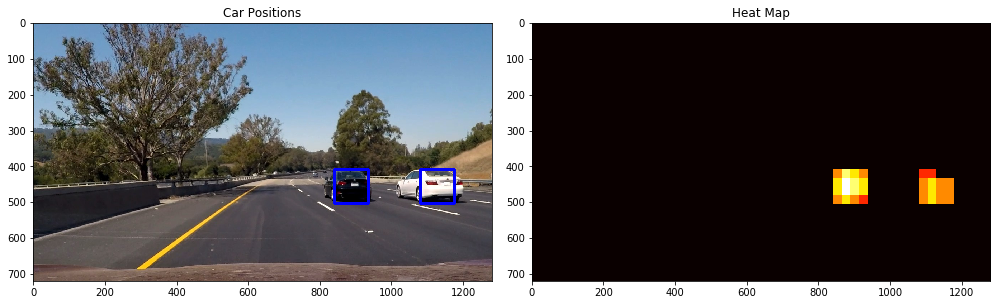

In [92]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,window_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('examples/heatmap.png')

## Cell 11: Video Pipeline

In [93]:
def pipeline(image,svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,\
             ystart,ystop,scale_list = [1,2]):
    draw_image = np.copy(image)
    
    window_img, window_list = find_cars_multiscales(image, ystart, ystop, scale_list, svc, X_scaler, \
                                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,window_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [94]:
test_images_path = glob.glob('test_images/test*.jpg')
test_images = []
for test_image_path in test_images_path:
    test_image = mpimg.imread(test_image_path)
    test_images.append(test_image)

image1 = test_images[0]
image_draw1 = pipeline(image1,svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, \
                       hist_bins,ystart,ystop,scale_list = scale)
image2 = test_images[1]
image_draw2 = pipeline(image2,svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, \
                       hist_bins,ystart,ystop,scale_list = scale)
image3 = test_images[2]
image_draw3 = pipeline(image3,svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, \
                       hist_bins,ystart,ystop,scale_list = scale)
image4 = test_images[3]
image_draw4 = pipeline(image4,svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, \
                       hist_bins,ystart,ystop,scale_list = scale)
image5 = test_images[4]
image_draw5 = pipeline(image5,svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, \
                       hist_bins,ystart,ystop,scale_list = scale)
image6 = test_images[5]
image_draw6 = pipeline(image6,svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, \
                       hist_bins,ystart,ystop,scale_list = scale)


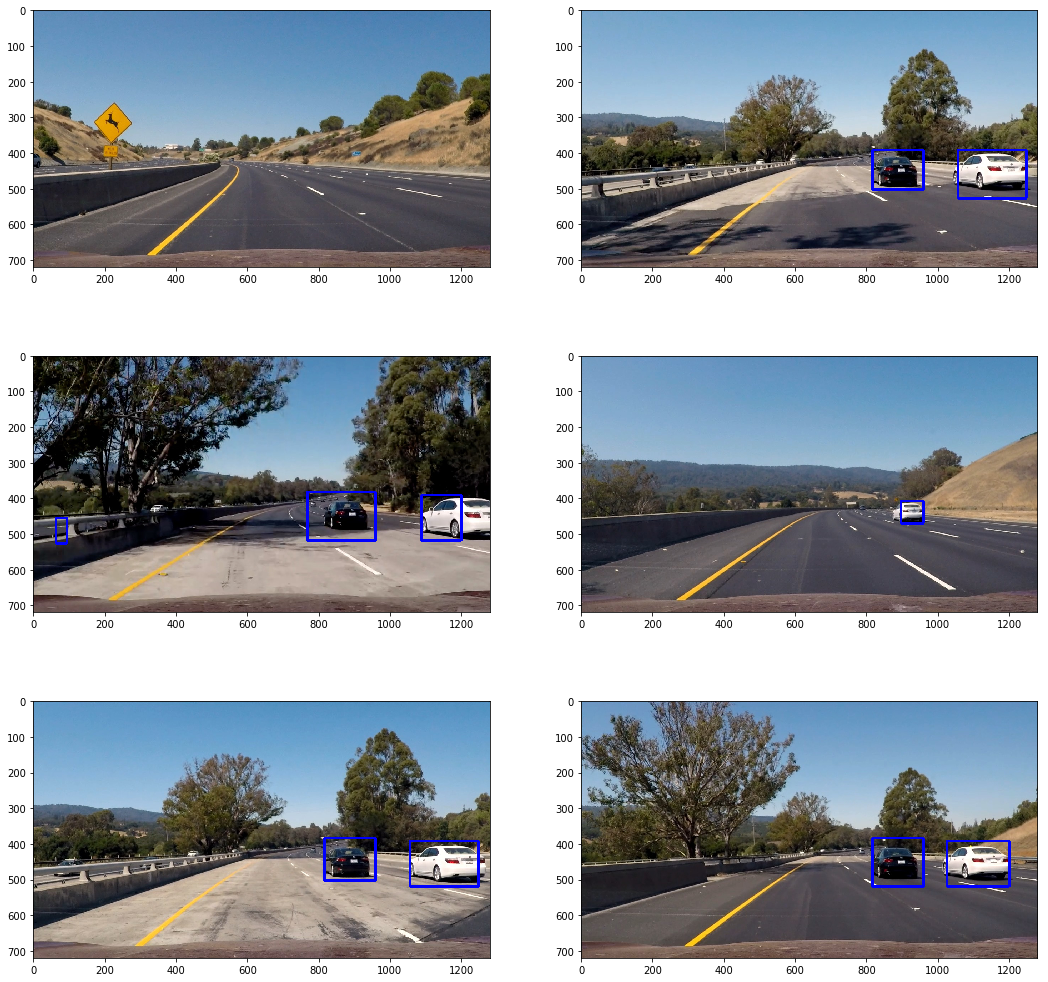

In [95]:
# Plot the examples
fig = plt.figure(figsize=(18,18))
plt.subplot(321)
plt.imshow(image_draw1, cmap='gray')
plt.subplot(322)
plt.imshow(image_draw2, cmap='gray')

plt.subplot(323)
plt.imshow(image_draw3, cmap='gray')
plt.subplot(324)
plt.imshow(image_draw4, cmap='gray')

plt.subplot(325)
plt.imshow(image_draw5, cmap='gray')
plt.subplot(326)
plt.imshow(image_draw6, cmap='gray')

plt.savefig('examples/detecttest.png')

In [96]:
from moviepy.editor import VideoFileClip

def VideoPipeline(inputVideo, outputVideo,svc,X_scaler, orient, pix_per_cell, cell_per_block, \
                  spatial_size, hist_bins,ystart,ystop,scale_list):
    myclip = VideoFileClip(inputVideo)
    clip = myclip.fl_image(lambda image: pipeline(image,svc,X_scaler, orient, pix_per_cell, \
                                                  cell_per_block, spatial_size, hist_bins,ystart,ystop,scale_list))
    clip.write_videofile(outputVideo, audio=False)
    
VideoPipeline('test_video.mp4', 'test_video_result.mp4',svc,X_scaler, orient, pix_per_cell, \
              cell_per_block, spatial_size, hist_bins,ystart,ystop,scale_list = scale)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4






  0%|          | 0/39 [00:00<?, ?it/s]



  3%|▎         | 1/39 [00:01<00:57,  1.50s/it]



  5%|▌         | 2/39 [00:03<00:55,  1.51s/it]



  8%|▊         | 3/39 [00:04<00:54,  1.50s/it]



 10%|█         | 4/39 [00:05<00:52,  1.49s/it]



 13%|█▎        | 5/39 [00:07<00:50,  1.49s/it]



 15%|█▌        | 6/39 [00:08<00:48,  1.48s/it]



 18%|█▊        | 7/39 [00:10<00:47,  1.47s/it]



 21%|██        | 8/39 [00:11<00:45,  1.47s/it]



 23%|██▎       | 9/39 [00:13<00:44,  1.47s/it]



 26%|██▌       | 10/39 [00:14<00:42,  1.48s/it]



 28%|██▊       | 11/39 [00:16<00:41,  1.50s/it]



 31%|███       | 12/39 [00:17<00:40,  1.51s/it]



 33%|███▎      | 13/39 [00:19<00:39,  1.52s/it]



 36%|███▌      | 14/39 [00:20<00:37,  1.50s/it]



 38%|███▊      | 15/39 [00:22<00:35,  1.49s/it]



 41%|████      | 16/39 [00:23<00:34,  1.49s/it]



 44%|████▎     | 17/39 [00:25<00:32,  1.49s/it]



 46%|████▌     | 18/39 [00:26<00:31,  1.48s/it]



 49%|████▊     | 19/39 [00:28<00:29,  1.48s/i

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 



In [97]:
VideoPipeline('project_video.mp4', 'project_video_result.mp4',svc,X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart,ystop,scale_list = scale)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:01<31:34,  1.50s/it]



  0%|          | 2/1261 [00:02<31:25,  1.50s/it]



  0%|          | 3/1261 [00:04<31:23,  1.50s/it]



  0%|          | 4/1261 [00:06<31:32,  1.51s/it]



  0%|          | 5/1261 [00:07<31:40,  1.51s/it]



  0%|          | 6/1261 [00:09<31:44,  1.52s/it]



  1%|          | 7/1261 [00:10<31:36,  1.51s/it]



  1%|          | 8/1261 [00:12<31:41,  1.52s/it]



  1%|          | 9/1261 [00:13<31:39,  1.52s/it]



  1%|          | 10/1261 [00:15<31:27,  1.51s/it]



  1%|          | 11/1261 [00:16<31:23,  1.51s/it]



  1%|          | 12/1261 [00:18<31:23,  1.51s/it]



  1%|          | 13/1261 [00:19<31:19,  1.51s/it]



  1%|          | 14/1261 [00:21<31:21,  1.51s/it]



  1%|          | 15/1261 [00:22<31:17,  1.51s/it]



  1%|▏         | 16/1261 [00:24<31:16,  1.51s/it]



  1%|▏         | 17/1261 [00:25<31:23,  1.51s/it]



  1%|▏         | 18/1261 [00:27<31:31,  1.52s/it]



  2%|▏ 

 10%|▉         | 125/1261 [03:08<28:29,  1.51s/it]



 10%|▉         | 126/1261 [03:09<28:23,  1.50s/it]



 10%|█         | 127/1261 [03:11<28:25,  1.50s/it]



 10%|█         | 128/1261 [03:12<28:14,  1.50s/it]



 10%|█         | 129/1261 [03:14<28:12,  1.50s/it]



 10%|█         | 130/1261 [03:15<28:12,  1.50s/it]



 10%|█         | 131/1261 [03:17<28:13,  1.50s/it]



 10%|█         | 132/1261 [03:18<28:24,  1.51s/it]



 11%|█         | 133/1261 [03:20<28:28,  1.51s/it]



 11%|█         | 134/1261 [03:21<28:05,  1.50s/it]



 11%|█         | 135/1261 [03:23<28:00,  1.49s/it]



 11%|█         | 136/1261 [03:24<28:00,  1.49s/it]



 11%|█         | 137/1261 [03:26<28:06,  1.50s/it]



 11%|█         | 138/1261 [03:27<27:55,  1.49s/it]



 11%|█         | 139/1261 [03:28<27:48,  1.49s/it]



 11%|█         | 140/1261 [03:30<27:51,  1.49s/it]



 11%|█         | 141/1261 [03:31<27:49,  1.49s/it]



 11%|█▏        | 142/1261 [03:33<27:45,  1.49s/it]



 11%|█▏        | 143/1261 [0

 20%|█▉        | 249/1261 [06:12<24:48,  1.47s/it]



 20%|█▉        | 250/1261 [06:14<24:56,  1.48s/it]



 20%|█▉        | 251/1261 [06:15<24:58,  1.48s/it]



 20%|█▉        | 252/1261 [06:17<25:07,  1.49s/it]



 20%|██        | 253/1261 [06:18<25:05,  1.49s/it]



 20%|██        | 254/1261 [06:20<25:07,  1.50s/it]



 20%|██        | 255/1261 [06:21<25:01,  1.49s/it]



 20%|██        | 256/1261 [06:23<25:03,  1.50s/it]



 20%|██        | 257/1261 [06:24<25:01,  1.50s/it]



 20%|██        | 258/1261 [06:26<24:57,  1.49s/it]



 21%|██        | 259/1261 [06:27<24:54,  1.49s/it]



 21%|██        | 260/1261 [06:29<24:47,  1.49s/it]



 21%|██        | 261/1261 [06:30<24:50,  1.49s/it]



 21%|██        | 262/1261 [06:32<24:48,  1.49s/it]



 21%|██        | 263/1261 [06:33<24:42,  1.49s/it]



 21%|██        | 264/1261 [06:35<24:44,  1.49s/it]



 21%|██        | 265/1261 [06:36<24:53,  1.50s/it]



 21%|██        | 266/1261 [06:38<24:49,  1.50s/it]



 21%|██        | 267/1261 [0

 30%|██▉       | 373/1261 [09:16<21:40,  1.46s/it]



 30%|██▉       | 374/1261 [09:18<21:43,  1.47s/it]



 30%|██▉       | 375/1261 [09:19<21:34,  1.46s/it]



 30%|██▉       | 376/1261 [09:21<21:30,  1.46s/it]



 30%|██▉       | 377/1261 [09:22<21:28,  1.46s/it]



 30%|██▉       | 378/1261 [09:23<21:21,  1.45s/it]



 30%|███       | 379/1261 [09:25<21:22,  1.45s/it]



 30%|███       | 380/1261 [09:26<21:22,  1.46s/it]



 30%|███       | 381/1261 [09:28<21:25,  1.46s/it]



 30%|███       | 382/1261 [09:29<21:28,  1.47s/it]



 30%|███       | 383/1261 [09:31<21:38,  1.48s/it]



 30%|███       | 384/1261 [09:32<21:55,  1.50s/it]



 31%|███       | 385/1261 [09:34<22:00,  1.51s/it]



 31%|███       | 386/1261 [09:35<22:02,  1.51s/it]



 31%|███       | 387/1261 [09:37<21:58,  1.51s/it]



 31%|███       | 388/1261 [09:38<21:35,  1.48s/it]



 31%|███       | 389/1261 [09:40<21:27,  1.48s/it]



 31%|███       | 390/1261 [09:41<21:31,  1.48s/it]



 31%|███       | 391/1261 [0

 39%|███▉      | 497/1261 [12:23<19:07,  1.50s/it]



 39%|███▉      | 498/1261 [12:24<19:07,  1.50s/it]



 40%|███▉      | 499/1261 [12:26<19:03,  1.50s/it]



 40%|███▉      | 500/1261 [12:27<18:55,  1.49s/it]



 40%|███▉      | 501/1261 [12:29<18:58,  1.50s/it]



 40%|███▉      | 502/1261 [12:30<18:55,  1.50s/it]



 40%|███▉      | 503/1261 [12:32<18:55,  1.50s/it]



 40%|███▉      | 504/1261 [12:33<18:57,  1.50s/it]



 40%|████      | 505/1261 [12:35<18:56,  1.50s/it]



 40%|████      | 506/1261 [12:36<18:59,  1.51s/it]



 40%|████      | 507/1261 [12:38<18:46,  1.49s/it]



 40%|████      | 508/1261 [12:39<18:34,  1.48s/it]



 40%|████      | 509/1261 [12:40<18:31,  1.48s/it]



 40%|████      | 510/1261 [12:42<18:24,  1.47s/it]



 41%|████      | 511/1261 [12:43<18:36,  1.49s/it]



 41%|████      | 512/1261 [12:45<18:38,  1.49s/it]



 41%|████      | 513/1261 [12:46<18:28,  1.48s/it]



 41%|████      | 514/1261 [12:48<18:19,  1.47s/it]



 41%|████      | 515/1261 [1

 49%|████▉     | 621/1261 [15:28<16:10,  1.52s/it]



 49%|████▉     | 622/1261 [15:30<16:07,  1.51s/it]



 49%|████▉     | 623/1261 [15:31<16:01,  1.51s/it]



 49%|████▉     | 624/1261 [15:33<15:50,  1.49s/it]



 50%|████▉     | 625/1261 [15:34<15:59,  1.51s/it]



 50%|████▉     | 626/1261 [15:36<16:02,  1.52s/it]



 50%|████▉     | 627/1261 [15:37<16:01,  1.52s/it]



 50%|████▉     | 628/1261 [15:39<16:01,  1.52s/it]



 50%|████▉     | 629/1261 [15:40<15:58,  1.52s/it]



 50%|████▉     | 630/1261 [15:42<15:51,  1.51s/it]



 50%|█████     | 631/1261 [15:43<15:51,  1.51s/it]



 50%|█████     | 632/1261 [15:45<15:54,  1.52s/it]



 50%|█████     | 633/1261 [15:46<15:50,  1.51s/it]



 50%|█████     | 634/1261 [15:48<15:45,  1.51s/it]



 50%|█████     | 635/1261 [15:49<15:47,  1.51s/it]



 50%|█████     | 636/1261 [15:51<15:42,  1.51s/it]



 51%|█████     | 637/1261 [15:52<15:37,  1.50s/it]



 51%|█████     | 638/1261 [15:54<15:36,  1.50s/it]



 51%|█████     | 639/1261 [1

 59%|█████▉    | 745/1261 [18:34<13:01,  1.51s/it]



 59%|█████▉    | 746/1261 [18:36<13:07,  1.53s/it]



 59%|█████▉    | 747/1261 [18:37<13:11,  1.54s/it]



 59%|█████▉    | 748/1261 [18:39<13:11,  1.54s/it]



 59%|█████▉    | 749/1261 [18:40<13:03,  1.53s/it]



 59%|█████▉    | 750/1261 [18:42<13:01,  1.53s/it]



 60%|█████▉    | 751/1261 [18:43<12:53,  1.52s/it]



 60%|█████▉    | 752/1261 [18:45<12:50,  1.51s/it]



 60%|█████▉    | 753/1261 [18:46<12:42,  1.50s/it]



 60%|█████▉    | 754/1261 [18:48<12:34,  1.49s/it]



 60%|█████▉    | 755/1261 [18:49<12:28,  1.48s/it]



 60%|█████▉    | 756/1261 [18:51<12:34,  1.49s/it]



 60%|██████    | 757/1261 [18:52<12:35,  1.50s/it]



 60%|██████    | 758/1261 [18:54<12:33,  1.50s/it]



 60%|██████    | 759/1261 [18:55<12:33,  1.50s/it]



 60%|██████    | 760/1261 [18:57<12:30,  1.50s/it]



 60%|██████    | 761/1261 [18:58<12:27,  1.49s/it]



 60%|██████    | 762/1261 [19:00<12:28,  1.50s/it]



 61%|██████    | 763/1261 [1

 69%|██████▉   | 869/1261 [21:41<10:06,  1.55s/it]



 69%|██████▉   | 870/1261 [21:42<10:05,  1.55s/it]



 69%|██████▉   | 871/1261 [21:44<10:05,  1.55s/it]



 69%|██████▉   | 872/1261 [21:45<10:02,  1.55s/it]



 69%|██████▉   | 873/1261 [21:47<10:00,  1.55s/it]



 69%|██████▉   | 874/1261 [21:49<10:00,  1.55s/it]



 69%|██████▉   | 875/1261 [21:50<09:56,  1.55s/it]



 69%|██████▉   | 876/1261 [21:52<09:53,  1.54s/it]



 70%|██████▉   | 877/1261 [21:53<09:51,  1.54s/it]



 70%|██████▉   | 878/1261 [21:55<09:53,  1.55s/it]



 70%|██████▉   | 879/1261 [21:56<09:52,  1.55s/it]



 70%|██████▉   | 880/1261 [21:58<09:50,  1.55s/it]



 70%|██████▉   | 881/1261 [21:59<09:46,  1.54s/it]



 70%|██████▉   | 882/1261 [22:01<09:45,  1.54s/it]



 70%|███████   | 883/1261 [22:02<09:40,  1.54s/it]



 70%|███████   | 884/1261 [22:04<09:35,  1.53s/it]



 70%|███████   | 885/1261 [22:05<09:29,  1.51s/it]



 70%|███████   | 886/1261 [22:07<09:25,  1.51s/it]



 70%|███████   | 887/1261 [2

 79%|███████▊  | 993/1261 [24:51<06:53,  1.54s/it]



 79%|███████▉  | 994/1261 [24:52<06:52,  1.54s/it]



 79%|███████▉  | 995/1261 [24:54<06:52,  1.55s/it]



 79%|███████▉  | 996/1261 [24:55<06:52,  1.56s/it]



 79%|███████▉  | 997/1261 [24:57<06:53,  1.56s/it]



 79%|███████▉  | 998/1261 [24:58<06:50,  1.56s/it]



 79%|███████▉  | 999/1261 [25:00<06:47,  1.55s/it]



 79%|███████▉  | 1000/1261 [25:01<06:46,  1.56s/it]



 79%|███████▉  | 1001/1261 [25:03<06:44,  1.56s/it]



 79%|███████▉  | 1002/1261 [25:05<06:44,  1.56s/it]



 80%|███████▉  | 1003/1261 [25:06<06:45,  1.57s/it]



 80%|███████▉  | 1004/1261 [25:08<06:45,  1.58s/it]



 80%|███████▉  | 1005/1261 [25:09<06:41,  1.57s/it]



 80%|███████▉  | 1006/1261 [25:11<06:38,  1.56s/it]



 80%|███████▉  | 1007/1261 [25:12<06:35,  1.56s/it]



 80%|███████▉  | 1008/1261 [25:14<06:32,  1.55s/it]



 80%|████████  | 1009/1261 [25:16<06:30,  1.55s/it]



 80%|████████  | 1010/1261 [25:17<06:30,  1.55s/it]



 80%|████████  | 

 88%|████████▊ | 1115/1261 [27:58<03:43,  1.53s/it]



 89%|████████▊ | 1116/1261 [28:00<03:42,  1.53s/it]



 89%|████████▊ | 1117/1261 [28:01<03:40,  1.53s/it]



 89%|████████▊ | 1118/1261 [28:03<03:38,  1.53s/it]



 89%|████████▊ | 1119/1261 [28:04<03:37,  1.53s/it]



 89%|████████▉ | 1120/1261 [28:06<03:34,  1.52s/it]



 89%|████████▉ | 1121/1261 [28:07<03:33,  1.52s/it]



 89%|████████▉ | 1122/1261 [28:09<03:31,  1.52s/it]



 89%|████████▉ | 1123/1261 [28:10<03:29,  1.52s/it]



 89%|████████▉ | 1124/1261 [28:12<03:28,  1.52s/it]



 89%|████████▉ | 1125/1261 [28:13<03:29,  1.54s/it]



 89%|████████▉ | 1126/1261 [28:15<03:28,  1.55s/it]



 89%|████████▉ | 1127/1261 [28:16<03:26,  1.54s/it]



 89%|████████▉ | 1128/1261 [28:18<03:24,  1.54s/it]



 90%|████████▉ | 1129/1261 [28:19<03:23,  1.54s/it]



 90%|████████▉ | 1130/1261 [28:21<03:22,  1.55s/it]



 90%|████████▉ | 1131/1261 [28:23<03:22,  1.56s/it]



 90%|████████▉ | 1132/1261 [28:24<03:19,  1.55s/it]



 90%|█████

 98%|█████████▊| 1237/1261 [31:06<00:37,  1.54s/it]



 98%|█████████▊| 1238/1261 [31:07<00:35,  1.54s/it]



 98%|█████████▊| 1239/1261 [31:09<00:33,  1.53s/it]



 98%|█████████▊| 1240/1261 [31:10<00:32,  1.53s/it]



 98%|█████████▊| 1241/1261 [31:12<00:30,  1.54s/it]



 98%|█████████▊| 1242/1261 [31:13<00:29,  1.54s/it]



 99%|█████████▊| 1243/1261 [31:15<00:27,  1.54s/it]



 99%|█████████▊| 1244/1261 [31:16<00:26,  1.54s/it]



 99%|█████████▊| 1245/1261 [31:18<00:24,  1.54s/it]



 99%|█████████▉| 1246/1261 [31:19<00:23,  1.54s/it]



 99%|█████████▉| 1247/1261 [31:21<00:21,  1.54s/it]



 99%|█████████▉| 1248/1261 [31:23<00:20,  1.55s/it]



 99%|█████████▉| 1249/1261 [31:24<00:18,  1.55s/it]



 99%|█████████▉| 1250/1261 [31:26<00:17,  1.55s/it]



 99%|█████████▉| 1251/1261 [31:27<00:15,  1.54s/it]



 99%|█████████▉| 1252/1261 [31:29<00:13,  1.54s/it]



 99%|█████████▉| 1253/1261 [31:30<00:12,  1.54s/it]



 99%|█████████▉| 1254/1261 [31:32<00:10,  1.54s/it]



100%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

